<a href="https://colab.research.google.com/github/UkeshThapa/Human-Activities-recognition/blob/main/Research_Human_activities_Recognition_TML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Research on Human Activities Recognition with TML
#### @author1 : John Bernardo
#### @email1 : jaybz.bernardo@gmail.com

####
#### @author2 : Bipun Man Pati Gubaju
#### @email2 : bemaanpati@gmail.com

#### ----------------------------------------------------------------------------------------------------------------------------------------------------------------------####



#### Code By:
#### @author : Ukesh Thapa
#### @email : yukeshthapa8@gmail.com


In [1]:
# import library

import numpy as np
import pandas as pd
import seaborn as sns
from tqdm import tqdm
import matplotlib.pyplot as plt


from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler



from sklearn.preprocessing import label_binarize
from sklearn.model_selection import GridSearchCV, StratifiedKFold,cross_val_score, KFold
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix,precision_score, recall_score, f1_score, roc_auc_score,precision_recall_curve,average_precision_score



# model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC


In [2]:
def load_dataset_and_merge(file_paths):
  dfs = []

  # Loop through each file, read it into a DataFrame, and append to the list
  for file_path in file_paths:
      df = pd.read_excel(file_path)
      dfs.append(df)
  combined_df = pd.concat(dfs,axis=0, ignore_index=True)

  return combined_df



xlsx_name = ["aung","aung_ph","bipun","john","kaung","kavin","manash","person_2","person_3","praew","su"]



In [4]:

# file_path = "/content/drive/MyDrive/Colab Notebooks/Human Activities Recognition/Dataset/2 Sensors/non-overlapping/Train_Test_Data"
file_path = "/content/drive/MyDrive/Colab Notebooks/Human Activities Recognition/Dataset/2 Sensors/50_-overlapping/Train_Test_Data"

cv_data_name = []
for name in xlsx_name:
    cv_data_name.append(f"{file_path}/final_{name}.xlsx")

df_all = load_dataset_and_merge(cv_data_name)

normalize_all_data = df_all.iloc[:, :-1]
scaler = MinMaxScaler()
scaler.fit(normalize_all_data)

df_all.iloc[:, :-1] = scaler.transform(normalize_all_data)

X = df_all.iloc[:, :-1].values
y = df_all['output'].values

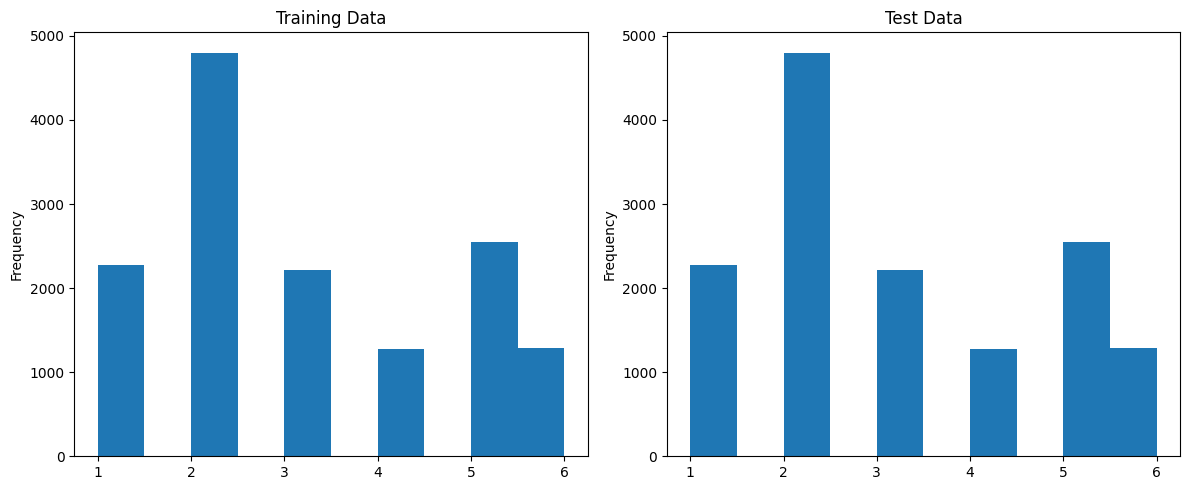

In [5]:
# Data visulaization

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns of subplots

# Plot the output column for the training DataFrame in the first subplot (ax1)
ax1.set_title('Training Data')
# Add your visualization for the output column of the training data (e.g., histogram, bar plot, etc.)
df_all['output'].plot(kind='hist', ax=ax1)

# Plot the output column for the test DataFrame in the second subplot (ax2)
ax2.set_title('Test Data')
# Add your visualization for the output column of the test data (e.g., histogram, bar plot, etc.)
df_all['output'].plot(kind='hist', ax=ax2)

# Adjust spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

# Cross Validation

# Model

In [6]:
### KNN Params

# param_grid = {
#     'n_neighbors': [1, 3, 5, 7, 9],
#     'weights': ['uniform', 'distance'],
#     'p': [1, 2]
# }

### Tree params
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
}

## Models
# model = KNeighborsClassifier()
# model = KNeighborsClassifier(metric='cosine')
model = DecisionTreeClassifier()




In [7]:

# Initialize variables to store the best model and its evaluation results
best_model = None
best_f1 = 0.0
best_train_f1 = 0.0
best_test_f1 = 0.0
best_validation_f1 = 0.0
best_confusion_matrix = None
best_precision_recall_curve = None



# Initialize lists to store F1 scores for each fold
scores = []
folds = []


# Define the outer cross-validation loop
outer_cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)



# Create a tqdm progress bar for the combined outer and inner loop
for fold_index, (train_index, test_index) in enumerate(tqdm(outer_cv.split(X, y), total=5, desc="Outer CV Progress")):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

    # Create an inner cross-validation loop for hyperparameter tuning
    inner_cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

    precision_recall_curves_in_fold = [None] * 6


    # Create a tqdm progress bar for the inner loop
    for train_index, val_index in inner_cv.split(X_train, y_train):
        X_train_inner, X_val = X_train[train_index], X_train[val_index]
        y_train_inner, y_val = y_train[train_index], y_train[val_index]

        # Create an inner grid search with the KNN model and parameter grid
        grid_search = GridSearchCV(estimator=model, param_grid=param_grid, cv=inner_cv, scoring='f1_micro')

        # Fit the grid search on the training data
        grid_search.fit(X_train_inner, y_train_inner)

        # Get the best hyperparameters from the grid search
        best_params = grid_search.best_params_

        # Create a KNN classifier with the best hyperparameters
        model = DecisionTreeClassifier(**best_params)

        # Fit the best KNN classifier on the training data
        model.fit(X_train_inner, y_train_inner)

        # Calculate F1 scores for training, testing, and validation

        validation_f1 = f1_score(y_val, model.predict(X_val),average='micro')

        # Check if the validation F1 score is the highest
        if validation_f1 > best_f1:
            best_f1 = validation_f1
            best_model = model
            best_validation_f1 = validation_f1
            best_confusion_matrix = confusion_matrix(y_test, best_model.predict(X_test))

    # Calculate train, validation and testing with best model
    train_f1 = f1_score(y_train_inner, best_model.predict(X_train_inner),average='micro')
    validation_f1 = f1_score(y_val, best_model.predict(X_val),average='micro')
    test_f1 = f1_score(y_test, best_model.predict(X_test),average='micro')

    train_precision = precision_score(y_train_inner, best_model.predict(X_train_inner),average='micro')
    validation_precision = precision_score(y_val, best_model.predict(X_val),average='micro')
    test_precision = precision_score(y_test, best_model.predict(X_test),average='micro')

    train_recall = recall_score(y_train_inner, best_model.predict(X_train_inner),average='micro')
    validation_recall = recall_score(y_val, best_model.predict(X_val),average='micro')
    test_recall = recall_score(y_test, best_model.predict(X_test),average='micro')

    precision = dict()
    recall = dict()
    threshold = dict()
    average_precision = dict()
    y_true = y_test
    y_true_bin = label_binarize(y_true, classes=np.unique(y_true))  # One-hot encode true labels
    y_pred_probs = best_model.predict_proba(X_test)
    n_classes = y_true_bin.shape[1]

    for i in range(n_classes):
      precision[i], recall[i], threshold[i] = precision_recall_curve(y_true_bin[:, i], y_pred_probs[:, i])
      average_precision[i] = average_precision_score(y_true_bin[:, i], y_pred_probs[:, i])

    # Find the optimal threshold that maximizes F1-score for each class
    optimal_thresholds = dict()

    for i in range(n_classes):
      f1_scores = 2 * (precision[i] * recall[i]) / (precision[i] + recall[i])
      optimal_thresholds[i] = threshold[i][np.argmax(f1_scores)]

    # Store the precision-recall data and optimal thresholds for this fold
    fold_data = {
      'precision': precision,
      'recall': recall,
      'optimal_thresholds': optimal_thresholds,
      'average_precision': average_precision
    }

    folds.append(fold_data)

    score_dict = {
        'fold_number' : fold_index,
        'train' : {
            'f1_score' : train_f1,
            'precision' : train_precision,
            'recall' : train_recall
        },

        'validation' : {
            'f1_score' : validation_f1,
            'precision' : validation_precision,
            'recall' : validation_recall
        },
        'test' : {
            'f1_score' : test_f1,
            'precision' : test_precision,
            'recall' : test_recall
        },

        'confusion_matrics' : confusion_matrix(y_test, best_model.predict(X_test)),
        'precision_recall_curves' :  fold_data

    }


    scores.append(score_dict)


Outer CV Progress: 100%|██████████| 5/5 [4:23:14<00:00, 3158.88s/it]


In [8]:
 # Average All the scores

train_f1_values = []
train_precision_values = []
train_recall_values = []
validation_f1_values = []
validation_precision_values = []
validation_recall_values = []
test_f1_values = []
test_precision_values = []
test_recall_values = []

# Iterate through the list of scores to collect metric values
for fold_scores in scores:
    train_f1_values.append(fold_scores['train']['f1_score'])
    train_precision_values.append(fold_scores['train']['precision'])
    train_recall_values.append(fold_scores['train']['recall'])

    validation_f1_values.append(fold_scores['validation']['f1_score'])
    validation_precision_values.append(fold_scores['validation']['precision'])
    validation_recall_values.append(fold_scores['validation']['recall'])

    test_f1_values.append(fold_scores['test']['f1_score'])
    test_precision_values.append(fold_scores['test']['precision'])
    test_recall_values.append(fold_scores['test']['recall'])

# Calculate the average values for each metric
average_train_f1 = sum(train_f1_values) / len(train_f1_values)
average_train_precision = sum(train_precision_values) / len(train_precision_values)
average_train_recall = sum(train_recall_values) / len(train_recall_values)

average_validation_f1 = sum(validation_f1_values) / len(validation_f1_values)
average_validation_precision = sum(validation_precision_values) / len(validation_precision_values)
average_validation_recall = sum(validation_recall_values) / len(validation_recall_values)

average_test_f1 = sum(test_f1_values) / len(test_f1_values)
average_test_precision = sum(test_precision_values) / len(test_precision_values)
average_test_recall = sum(test_recall_values) / len(test_recall_values)

# Print or use the average values as needed
print("Average Train F1 Score:", average_train_f1)
print("Average Train Precision:", average_train_precision)
print("Average Train Recall:", average_train_recall)

print("Average Validation F1 Score:", average_validation_f1)
print("Average Validation Precision:", average_validation_precision)
print("Average Validation Recall:", average_validation_recall)

print("Average Test F1 Score:", average_test_f1)
print("Average Test Precision:", average_test_precision)
print("Average Test Recall:", average_test_recall)


Average Train F1 Score: 0.9762014898193139
Average Train Precision: 0.9762014898193139
Average Train Recall: 0.9762014898193139
Average Validation F1 Score: 0.9741319444444445
Average Validation Precision: 0.9741319444444445
Average Validation Recall: 0.9741319444444445
Average Test F1 Score: 0.9724362923753327
Average Test Precision: 0.9724362923753327
Average Test Recall: 0.9724362923753327


# Save Model

In [9]:
file_path = "/content/drive/MyDrive/Colab Notebooks/Human Activities Recognition/model/"
name = "2sensor_Overlapping_decision_tree_model"

import pickle

# Load the model from the pickle file
with open(f'{file_path}/{name}.pkl', 'wb') as file:
    pickle.dump(best_model, file)

# Now, 'loaded_model' contains your saved model


# Save Data in json File

In [10]:
import json

for entry in scores:
    entry['confusion_matrics'] = entry['confusion_matrics'].tolist()

    for key in entry['precision_recall_curves']['precision']:
        entry['precision_recall_curves']['precision'][key] = entry['precision_recall_curves']['precision'][key].tolist()

    for key in entry['precision_recall_curves']['recall']:
        entry['precision_recall_curves']['recall'][key] = entry['precision_recall_curves']['recall'][key].tolist()


# Load the list of dictionaries from the JSON file

with open(f'{file_path}/{name}_scores.json', 'w') as json_file:
    json.dump(scores, json_file)

# Pr curve

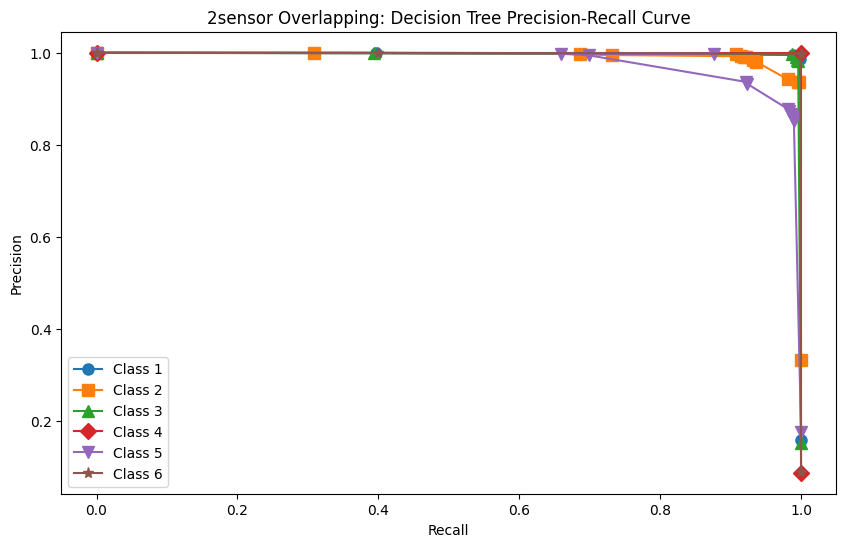

In [12]:
import matplotlib.pyplot as plt
import numpy as np

# Define the number of classes and markers
n_classes = 6
markers = ['o', 's', '^', 'D', 'v', '*']  # You can extend this list with other markers

# Create a sub-plot
plt.figure(figsize=(10, 6))

average_precision = [0] * n_classes

for class_idx in range(n_classes):
    # Calculate average precision and recall values
    precision = [fold['precision'][class_idx] for fold in folds]
    recall = [fold['recall'][class_idx] for fold in folds]

    # Find the maximum length among precision and recall lists
    max_length = max(len(precision[i]) for i in range(len(precision)))

    # Pad the precision and recall lists to have the same length
    padded_precision = [np.pad(precision[i], (0, max_length - len(precision[i])), 'constant', constant_values=np.nan) for i in range(len(precision))]
    padded_recall = [np.pad(recall[i], (0, max_length - len(recall[i])), 'constant', constant_values=np.nan) for i in range(len(recall))]

    # Calculate the mean precision and recall
    avg_precision = np.nanmean(padded_precision, axis=0)
    avg_recall = np.nanmean(padded_recall, axis=0)
    average_precision[class_idx] = avg_precision[-1]

    # Use a different marker for each class
    marker = markers[class_idx % len(markers)]

    plt.plot(avg_recall, avg_precision, marker=marker, markersize=8, label=f'Class {class_idx+1}')

plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('2sensor Overlapping: Decision Tree Precision-Recall Curve')
plt.legend(loc='best')

plt.show()


# Confusion Matrics

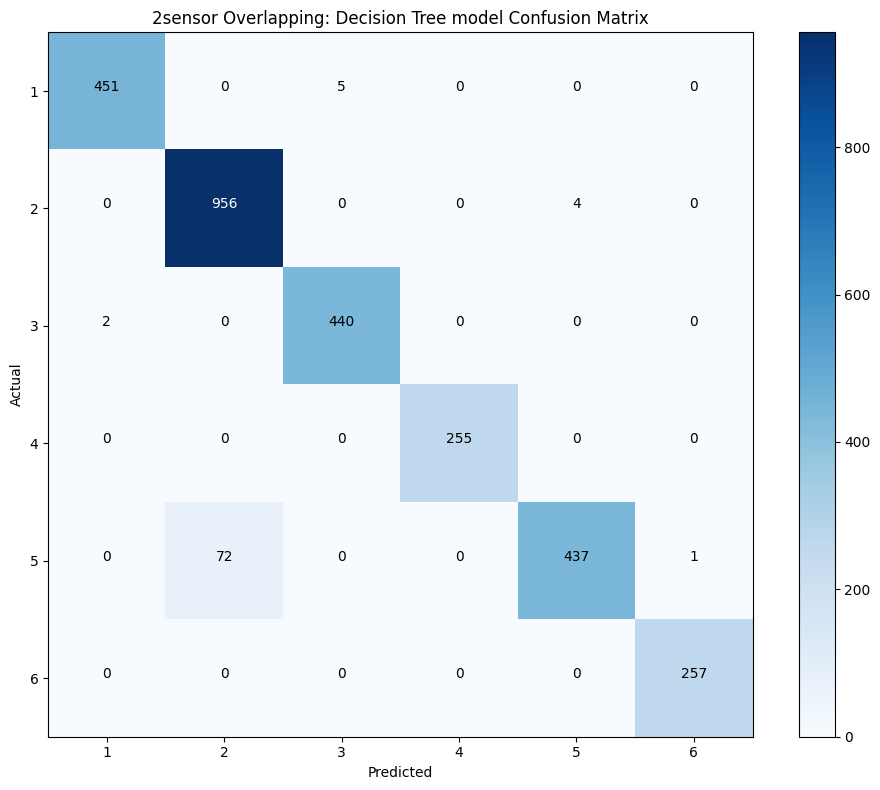

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# Sample confusion matrix data
confusion_matrix = best_confusion_matrix

# Create a heatmap to visualize the confusion matrix
plt.figure(figsize=(10, 8))
plt.imshow(confusion_matrix, interpolation='nearest', cmap=plt.get_cmap('Blues'))
plt.title('2sensor Overlapping: Decision Tree model Confusion Matrix')
plt.colorbar()

# Add labels for the x and y axes
classes = [1, 2, 3, 4, 5, 6]  # Replace with your class labels
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# Display the values in each cell of the heatmap
thresh = confusion_matrix.max() / 2.0
for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(confusion_matrix[i, j]), horizontalalignment="center", color="white" if confusion_matrix[i, j] > thresh else "black")

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.grid(False)  # Turn off grid lines
plt.show()
